In [30]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import mplcyberpunk
import matplotlib.pyplot as plt
plt.style.use('cyberpunk')
import os
from sklearn.metrics import f1_score
import random
import time
from io import BytesIO

In [31]:
device = 'cpu'

In [32]:
trnsfrms1 = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    # T.ColorJitter(
    #     brightness=0.1,  
    #     contrast=0.1,    
    #     saturation=0.1, 
    #     hue=0.05         
    # ),
    # T.RandomRotation(degrees=10),  
    # T.RandomHorizontalFlip(p=0.2),  
])

trnsfrms2 = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])


train_dataset = torchvision.datasets.ImageFolder('/Users/polyakovk/ds_bootcamp/nn-project/dataset/train', 
                                                 transform=trnsfrms1)
valid_dataset = torchvision.datasets.ImageFolder('/Users/polyakovk/ds_bootcamp/nn-project/dataset/test', 
                                                 transform=trnsfrms2)

In [33]:
train_dataset.class_to_idx
ind2class = {j:i for i,j in train_dataset.class_to_idx.items()}

In [34]:
file_path = 'class_names.json'

# Сохранение словаря в файл JSON
with open(file_path, 'w') as f:
    json.dump(ind2class, f)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

In [36]:
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [37]:
class Myresnet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(512,11)
        for i in self.model.parameters():
            i.requires_grad = False
        self.model.fc.weight.requires_grad = True
        self.model.fc.bias.requires_grad = True
    def forward(self, x):
        x = self.model(x)
        return x
    
model = Myresnet18()
model.to(device)

Myresnet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [39]:
def fit(
        model: torch.nn.Module, 
        n_epochs: int, 
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        history = None
        ) -> dict:

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
        'train_f1s': [],
        'valid_f1s': [],
    }
    model.to(device)
    model.train()
    for epoch in range(n_epochs):
        print(f'{epoch} эпоха обучения')
        model.train()
        batch_accs = []
        batch_losses = [] 
        batch_f1s = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            y_pred = model(images)
            loss = criterion(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).cpu().numpy().mean())

            # Calculate F1 score
            y_true = labels.cpu().numpy()
            y_pred_labels = y_pred.argmax(dim=1).cpu().numpy()
            batch_f1s.append(f1_score(y_true, y_pred_labels, average='weighted'))

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))
        history['train_f1s'].append(np.mean(batch_f1s))

        model.eval()
        batch_accs = []
        batch_losses = []
        batch_f1s = []
        
        for images, labels in valid_loader:
            with torch.no_grad():
                y_pred = model(images.to(device))
            loss = criterion(y_pred, labels.to(device))
            batch_losses.append(loss.item())
            batch_accs.append((y_pred.cpu().argmax(dim=1) == labels.cpu()).numpy().mean())

            # Calculate F1 score
            y_true = labels.cpu().numpy()
            y_pred_labels = y_pred.cpu().argmax(dim=1).numpy()
            batch_f1s.append(f1_score(y_true, y_pred_labels, average='weighted'))

        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))
        history['valid_f1s'].append(np.mean(batch_f1s))
        
        # печатаем результат
        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}, f1 {history["train_f1s"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}, f1 {history["valid_f1s"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history

In [40]:
logs = fit(model, 5, optimizer, train_loader, valid_loader)

0 эпоха обучения
train: accuracy 0.5408, loss 1.5756, f1 0.5051
valid: accuracy 0.7456, loss 0.9913, f1 0.7356
-----------------------------------

1 эпоха обучения
train: accuracy 0.7966, loss 0.7986, f1 0.7934
valid: accuracy 0.7959, loss 0.6957, f1 0.7916
-----------------------------------

2 эпоха обучения
train: accuracy 0.8332, loss 0.6168, f1 0.8321
valid: accuracy 0.8358, loss 0.5873, f1 0.8321
-----------------------------------

3 эпоха обучения
train: accuracy 0.8526, loss 0.5261, f1 0.8521
valid: accuracy 0.8275, loss 0.5417, f1 0.8234
-----------------------------------

4 эпоха обучения
train: accuracy 0.8657, loss 0.4794, f1 0.8654
valid: accuracy 0.8511, loss 0.5051, f1 0.8503
-----------------------------------



In [41]:
with open('training_history.json', 'w') as f:
        json.dump(logs, f, indent=4)

In [42]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    
    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()
    
    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()
    
    plt.show()

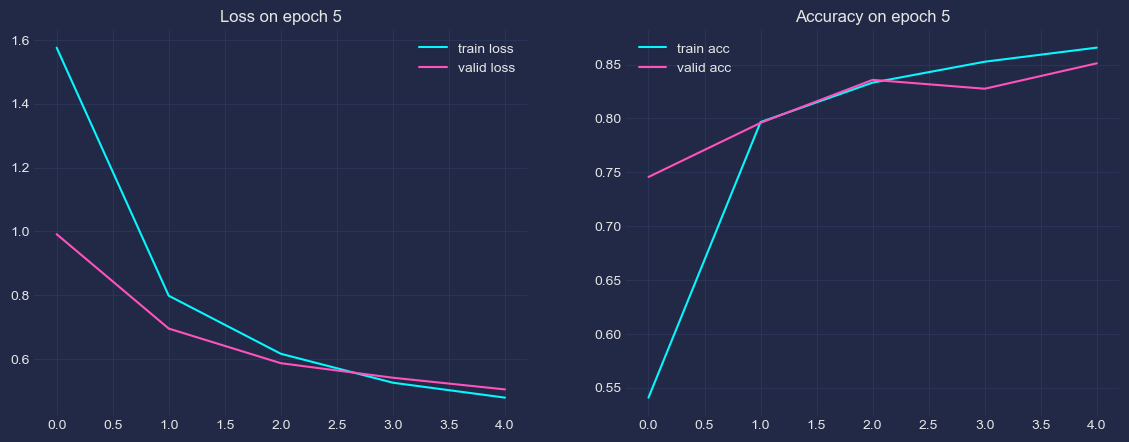

In [43]:
plot_history(logs)

Изображение с меткой 'glaze' по индексу 416
Предсказание выполнено за 0.0388 секунд


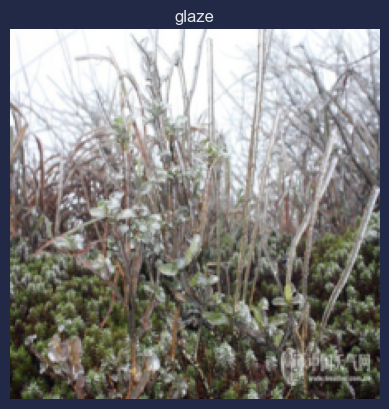

In [46]:
random_index = random.randint(0, len(valid_dataset) - 1)
image, label = valid_dataset[random_index]
class_name = valid_dataset.classes[label]
print(f"Изображение с меткой '{class_name}' по индексу {random_index}")
start_time = time.time()
with torch.inference_mode():
    pred_class = model(image.to(device).unsqueeze(0)).argmax().item()
end_time = time.time()
prediction_time = end_time - start_time
print(f"Предсказание выполнено за {prediction_time:.4f} секунд")
plt.imshow(image.permute(1, 2, 0))
plt.title(ind2class[pred_class])
plt.axis('off')
plt.show()

In [47]:
import requests
from PIL import Image
from io import BytesIO
import torch
import torchvision.transforms as T
from torchvision import models, io
import matplotlib.pyplot as plt
import time

def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSQaAs15lzVwOEZ9PZ2O2nl6g8gcSmDS7mjRg&s' 
image = load_image_from_url(image_url)
image = preprocess(image).to(device)

Предсказание выполнено за 0.0655 секунд


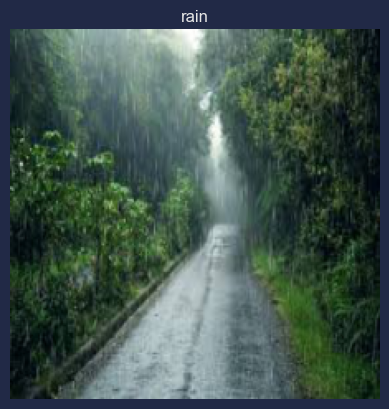

In [48]:
start_time = time.time()
model.to(device)
with torch.inference_mode():
    pred_class = model(image.to(device).unsqueeze(0)).argmax().item()
end_time = time.time()
prediction_time = end_time - start_time
print(f"Предсказание выполнено за {prediction_time:.4f} секунд")
plt.imshow(image.cpu().permute(1, 2, 0).numpy())
plt.title(ind2class[pred_class])
plt.axis('off')
plt.show()

In [49]:
torch.save(model.state_dict(), 'resnet_weight.pt')

In [50]:
torch.save(model, 'Myresnet18.py')

In [51]:
model = model.to('cpu')  # Переносим модель на CPU перед сохранением
torch.save(model.state_dict(), 'resnet_weight_cpu.pt')
torch.save(model, 'Myresnet18_cpu.py')


In [52]:
import torch
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(model, data_loader, device, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return cm

In [53]:
# Определите количество классов в вашем наборе данных
num_classes = len(train_dataset.classes)

# Вычислите матрицу ошибок на валидационном наборе данных
confusion_matrix = compute_confusion_matrix(model.to(device), valid_loader, device, num_classes)

# Сохраните матрицу ошибок в файл
# np.save('confusion_matrix.npy', confusion_matrix)


In [54]:
np.save('confusion_matrix.npy', confusion_matrix)